In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from ast import literal_eval
import re
from scipy import stats
from random import sample
#import scipy.stats as stats
import random
import re
import statistics
import seaborn as sns
import matplotlib.patches as mpatches

In [2]:
import sys  
sys.path.insert(0, '../scripts')

from D_plot_specificity_matrix_utils import (calc_binding_concordance)

In [3]:
def HLA_cd8_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace(",", "").replace("'","").split(" ")

def cdr3_lst_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace("'","").split(" ")

def epitope_converter(x):
    #define format of datetime
    return [y for y in x.replace("[","").replace("]","").replace("\n","").split("'") if (y != '') & (y != ' ')]

def peptide_hla_converter(x):
    return re.findall("\w+\s{1}\w{1}\d+", x.replace("[","").replace("]","").replace("\n","").replace("'",""))

def literal_converter(val):
    # replace NaN with '' and perform literal eval on the rest
    return [] if val == '' else literal_eval(val)

converters = {'peptide_HLA_lst': peptide_hla_converter,
              'umi_count_lst_mhc': literal_eval,
              'umi_count_lst_TRA': literal_converter,'umi_count_lst_TRB': literal_converter,
              'cdr3_lst_TRA': cdr3_lst_converter,
              'cdr3_lst_TRB': cdr3_lst_converter,
              'HLA_lst_mhc': cdr3_lst_converter,'HLA_cd8': HLA_cd8_converter} #

# Input

In [4]:
CAT_DIR = '../experiments/exp13/run2/cat/'

In [5]:
VALID = CAT_DIR + "eval_clonotypes/valid_ct.csv"

# Load

In [6]:
valid_df = pd.read_csv(VALID, converters=converters)#.fillna('') #.fillna(0)

In [7]:
valid_df.columns

Index(['gem', 'clonotype', 'num_clonotype', 'ct', 'genes_TRA', 'genes_TRB',
       'genes_lst_TRA', 'genes_lst_TRB', 'length_TRA', 'cdr1_TRA', 'cdr2_TRA',
       'cdr3_TRA', 'umi_count_TRA', 'umi_count_lst_TRA', 'delta_umi_TRA',
       'cdr3_lst_TRA', 'chain_count_TRA', 'single_TRA', 'length_TRB',
       'cdr1_TRB', 'cdr2_TRB', 'cdr3_TRB', 'umi_count_TRB',
       'umi_count_lst_TRB', 'delta_umi_TRB', 'cdr3_lst_TRB', 'chain_count_TRB',
       'single_TRB', 'single_chain_only', 'umi_count_tcr', 'cdr3_comb',
       'v_gene_TRA', 'j_gene_TRA', 'v_gene_TRB', 'j_gene_TRB', 'tcr_category',
       'no_filtration', 'exclude_single-chain_TCRs',
       'exclude_ambiguous_and_single-chain_TCRs', 'exclude_ambiguous_TCRs',
       'label', 'umi_count_mhc', 'umi_count_lst_mhc', 'delta_umi_mhc',
       'single_barcode_mhc', 'multiplets_mhc', 'umi_count_cd8',
       'umi_count_lst_cd8', 'delta_umi_cd8', 'single_barcode_cd8',
       'multiplets_cd8', 'detected_response', 'peptide_assayed', 'sample_id',
 

In [8]:
valid_df.fillna({'umi_count_mhc':0, 'delta_umi_mhc':0, 'umi_count_mhc_rel':0,
                 'umi_count_cd8':0, 'delta_umi_cd8':0,
                 'umi_count_TRA':0, 'delta_umi_TRA':0,
                 'umi_count_TRB':0, 'delta_umi_TRB':0,
                 'cdr3_TRA':'','cdr3_TRB':''}, inplace=True)

In [9]:
df = calc_binding_concordance(valid_df[(valid_df.umi_count_mhc >=2) &
                                       (valid_df.delta_umi_mhc >=1)].copy(), 'ct')

In [10]:
df.gem.to_csv('gem_1OS.csv', index=False, header=False)

# Main

In [11]:
df['binding_category'] = np.where(df.binding_concordance > 0.5, 'normal','outlier')

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcb19955ba8>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcb19955fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcb19955780>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcb1996c908>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcb1996cc50>],
 'means': []}

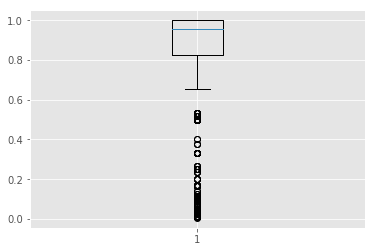

In [12]:
plt.boxplot(df.binding_concordance)

In [13]:
dfs = list()
for var, row in [('umi_count_mhc','UMI'),('delta_umi_mhc','ratio'),
                 ('umi_count_cd8','UMI'),('delta_umi_cd8','ratio'),
                 ('umi_count_TRA','UMI'),('delta_umi_TRA','ratio'),
                 ('umi_count_TRB','UMI'),('delta_umi_TRB','ratio')]:
    tmp = df[var].to_frame().rename(columns={var:'value'})
    tmp['col'] = var[-3:]
    tmp['row'] = row
    tmp['x'] = df.binding_category
    tmp['sample'] = df.sample_id
    
    dfs.append(tmp)

In [14]:
plt_df = pd.concat(dfs)

Text(0.5, 1.05, 'Difference between outliers and "normal" observations')

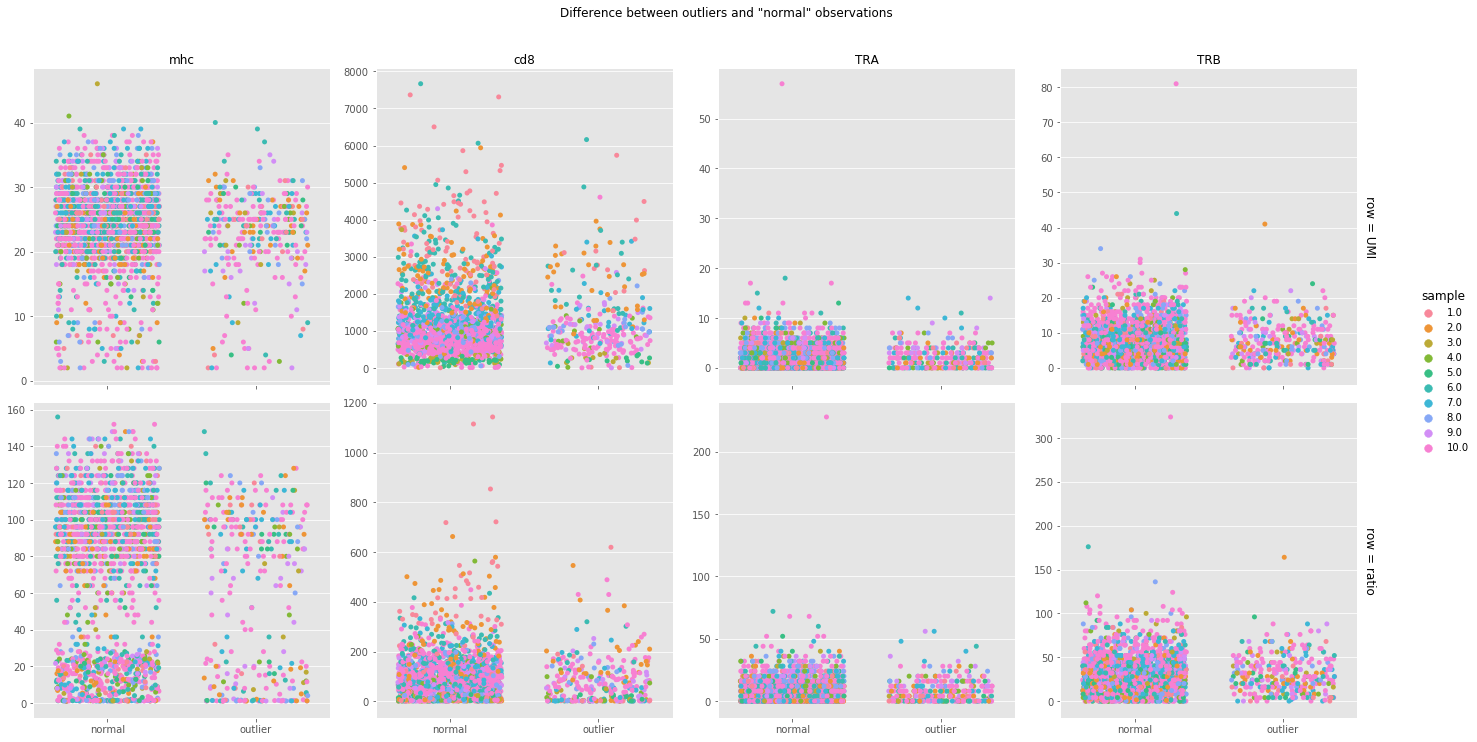

In [15]:
g = sns.catplot(data=plt_df, x='x', y='value', row='row', col='col', hue='sample', jitter=0.35, sharey=False, margin_titles=True)
g.set_titles(col_template="{col_name}")#, row_template="{row_name}"
g.set_ylabels('')
g.set_xlabels('')
plt.suptitle('Difference between outliers and "normal" observations', y=1.05)

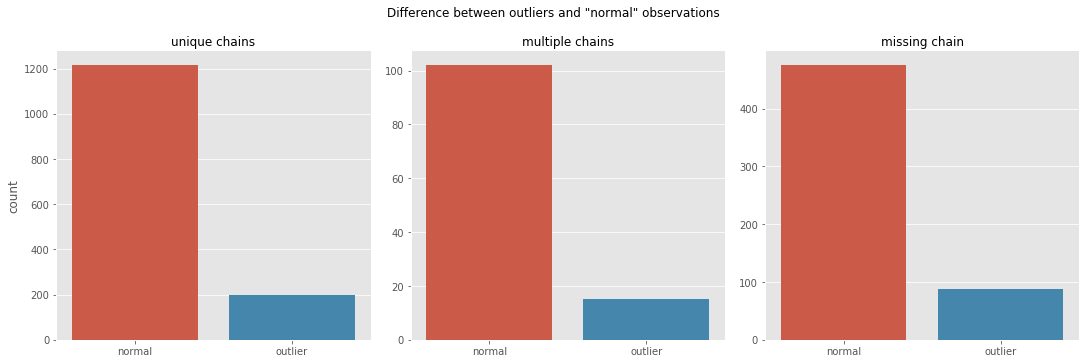

In [16]:
g = sns.catplot(data=df, x='binding_category', col='tcr_category', kind='count', sharey=False, margin_titles=True)
g.set_titles(col_template="{col_name}")#, row_template="{row_name}"
g.set_xlabels('')
plt.suptitle('Difference between outliers and "normal" observations', y=1.05)
plt.show()

In [17]:
smry = df.groupby(['binding_category','tcr_category']).size().to_frame().rename(columns={0:'freq'})

In [18]:
smry

freq
binding_category tcr_category         
normal           missing chain     475
                 multiple chains   102
                 unique chains    1215
outlier          missing chain      88
                 multiple chains    15
                 unique chains     199

In [19]:
smry.loc['normal','freq'] = smry.loc['normal','freq'].values / smry.loc['normal','freq'].sum() * 100

In [20]:
smry.loc['outlier','freq'] = smry.loc['outlier','freq'].values / smry.loc['outlier','freq'].sum() * 100

In [21]:
smry

freq
binding_category tcr_category              
normal           missing chain    26.506696
                 multiple chains   5.691964
                 unique chains    67.801339
outlier          missing chain    29.139073
                 multiple chains   4.966887
                 unique chains    65.894040

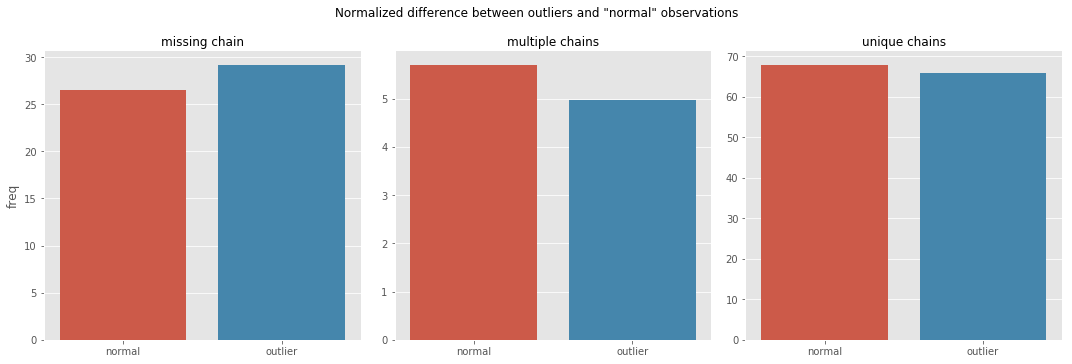

In [22]:
g = sns.catplot(data=smry.reset_index(), x='binding_category', y='freq', col='tcr_category', kind='bar', sharey=False, margin_titles=True)
g.set_titles(col_template="{col_name}")#, row_template="{row_name}"
g.set_xlabels('')
plt.suptitle('Normalized difference between outliers and "normal" observations', y=1.05)
plt.show()

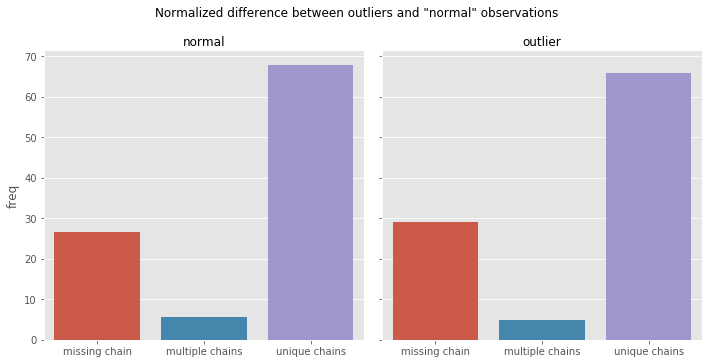

In [23]:
g = sns.catplot(data=smry.reset_index(), col='binding_category', y='freq', x='tcr_category', kind='bar', sharey=True, margin_titles=True)
g.set_titles(col_template="{col_name}")#, row_template="{row_name}"
g.set_xlabels('')
plt.suptitle('Normalized difference between outliers and "normal" observations', y=1.05)
plt.show()

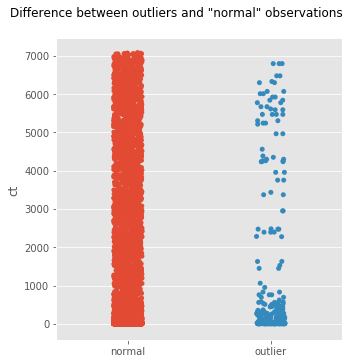

In [89]:
g = sns.catplot(data=df, x='binding_category', y='ct')
g.set_titles(col_template="{col_name}")#, row_template="{row_name}"
g.set_xlabels('')
plt.suptitle('Difference between outliers and "normal" observations', y=1.05)
plt.show()